In [24]:
import importlib
import sys
import os
import UAVenv
from UAVenv import UAVEnv
importlib.reload(UAVenv)
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import collections
import random

[[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 1. 1.]
  [0. 0. 1. 1. 1.]
  [0. 0. 1. 1. 1.]]

 [[1. 1. 1. 0. 0.]
  [1. 1. 1. 0. 0.]
  [1. 1. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 1. 1.]
  [0. 0. 1. 1. 1.]
  [0. 0. 1. 1. 1.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [1. 1. 1. 0. 0.]
  [1. 1. 1. 0. 0.]
  [1. 1. 1. 0. 0.]]]
5
8


In [25]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(32 * state_dim * state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # 添加通道维度 (batch, 1, 5, 5) en: add channel dimension
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class QValueNet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    # en: Q network with only one hidden layer
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(32 * state_dim * state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # 添加通道维度 (batch, 1, 5, 5) en: add channel dimension
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [26]:
class SAC:
    ''' 处理离散动作的SAC算法 '''
    # en: SAC algorithm for discrete actions
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 alpha_lr, target_entropy, tau, gamma, device):
        # 策略网络 en: Policy network
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        # 第一个Q网络 en: First Q network
        self.critic_1 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        # 第二个Q网络 en: Second Q network
        self.critic_2 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic_1 = QValueNet(state_dim, hidden_dim,
                                         action_dim).to(device)  # 第一个目标Q网络 en: First target Q network
        self.target_critic_2 = QValueNet(state_dim, hidden_dim,
                                         action_dim).to(device)  # 第二个目标Q网络 en: Second target Q network
        # 令目标Q网络的初始参数和Q网络一样 en: Initialize target Q networks with the same parameters
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(),
                                                   lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(),
                                                   lr=critic_lr)
        # 使用alpha的log值,可以使训练结果比较稳定 en: Use log value of alpha for stability 
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  # 可以对alpha求梯度 en: Allow gradient calculation for alpha
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha],
                                                    lr=alpha_lr)
        self.target_entropy = target_entropy  # 目标熵的大小 en: Target entropy size
        self.gamma = gamma
        self.tau = tau
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    # 计算目标Q值,直接用策略网络的输出概率进行期望计算 en: Calculate target Q value, directly use the output probabilities of the policy network for expectation calculation
    def calc_target(self, rewards, next_states, dones):
        next_probs = self.actor(next_states)
        next_log_probs = torch.log(next_probs + 1e-8)
        entropy = -torch.sum(next_probs * next_log_probs, dim=1, keepdim=True)
        q1_value = self.target_critic_1(next_states)
        q2_value = self.target_critic_2(next_states)
        min_qvalue = torch.sum(next_probs * torch.min(q1_value, q2_value),
                               dim=1,
                               keepdim=True)
        next_value = min_qvalue + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones)
        return td_target

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +
                                    param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)  # 动作不再是float类型 # en: Actions are no longer float type
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        # 更新两个Q网络 # en: Update two Q networks
        td_target = self.calc_target(rewards, next_states, dones)
        critic_1_q_values = self.critic_1(states).gather(1, actions)
        critic_1_loss = torch.mean(
            F.mse_loss(critic_1_q_values, td_target.detach()))
        critic_2_q_values = self.critic_2(states).gather(1, actions)
        critic_2_loss = torch.mean(
            F.mse_loss(critic_2_q_values, td_target.detach()))
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # 更新策略网络 # en: Update policy network
        probs = self.actor(states)
        log_probs = torch.log(probs + 1e-8)
        # 直接根据概率计算熵 # en: Directly calculate entropy based on probabilities
        entropy = -torch.sum(probs * log_probs, dim=1, keepdim=True)  #
        q1_value = self.critic_1(states)
        q2_value = self.critic_2(states)
        min_qvalue = torch.sum(probs * torch.min(q1_value, q2_value),
                               dim=1,
                               keepdim=True)  # 直接根据概率计算期望 # en: Directly calculate expectation based on probabilities
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy - min_qvalue)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新alpha值 # en: Update alpha value
        alpha_loss = torch.mean(
            (entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

In [27]:
def train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    return_list_2=[]
    steps_per_episode = []  # 添加新列表来记录每轮的步数   en: Add a new list to record the number of steps in each episode
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                state = env.reset()
                done = False
                step_count = 0  # 初始化步数计数器 en: Initialize step counter
                while not done:
                    step_count += 1  # 每执行一步操作，步数加1 en: Increment step counter by 1 for each action taken
                    actions = [agent.take_action(state[n]) for n in range(env.N)]
                    next_state, reward, done = env.step(actions)
                    for n, uav in enumerate(env.uavs):
                        if uav['done'] == False:
                            replay_buffer.add(state[n], actions[n], reward[n], next_state[n], done)
                    state = next_state
                    episode_return += sum(reward)
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
                        agent.update(transition_dict)
                return_list.append(episode_return)
                return_list_2.append(sum(sum(env.uncertainty_matrix))/100)
                steps_per_episode.append(step_count)  # 记录该轮的总步数 en: Record the total number of steps in this episode
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:]),
                        'uncertainty_matrix':
                        '%.3f' % np.mean(return_list_2[-10:]),
                        'avg_steps': 
                        '%.1f' % np.mean(steps_per_episode[-10:])  # 显示最近10轮的平均步数 en: Show the average number of steps in the last 10 episodes
                    })
                pbar.update(1)
    return return_list,return_list_2

In [28]:
class ReplayBuffer:
    ''' 经验回放池 '''
    # en: Experience replay buffer
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出 en: Queue, first in first out

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer en: Add data to the buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size en: Sample data from the buffer, number of samples is batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量 en: Number of data in the buffer
        return len(self.buffer)

In [30]:
actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
num_episodes = 1000
hidden_dim = 128
gamma = 0.99
tau = 0.005  # 软更新参数 en: Soft update parameter
buffer_size = 2000
minimal_size = 500
batch_size = 64
target_entropy = -np.log(8)
print(target_entropy)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")


env = UAVEnv()


replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.state_dim
action_dim = env.action_dim
agent = SAC(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, alpha_lr,
            target_entropy, tau, gamma, device)

return_list, return_list_2 = train_off_policy_agent(env, agent, num_episodes,
                                              replay_buffer, minimal_size,
                                              batch_size)

-2.0794415416798357


Iteration 9: 100%|██████████| 100/100 [01:20<00:00,  1.25it/s, episode=1000, return=1.358, uncertainty_matrix=0.548, avg_steps=64.0]


In [32]:
import pickle

# 保存
with open("msac_returns.pkl", "wb") as f:
    pickle.dump((return_list, return_list_2), f)

# 读取
with open("msac_returns.pkl", "rb") as f:
    return_list, return_list_2 = pickle.load(f)

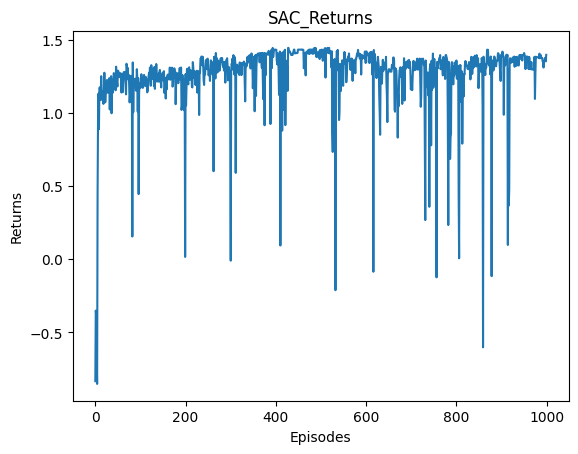

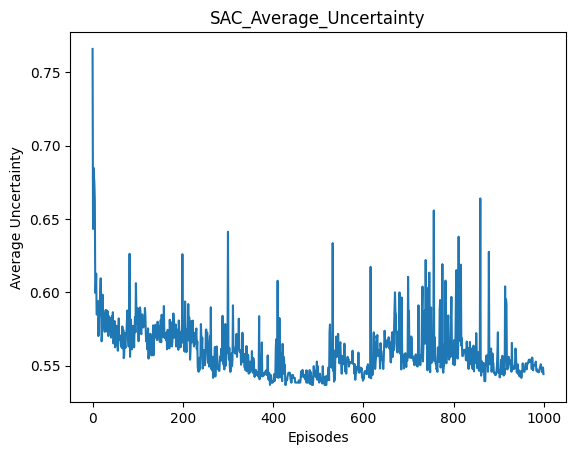

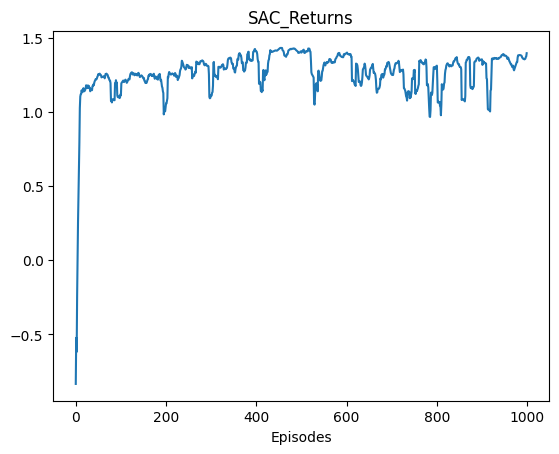

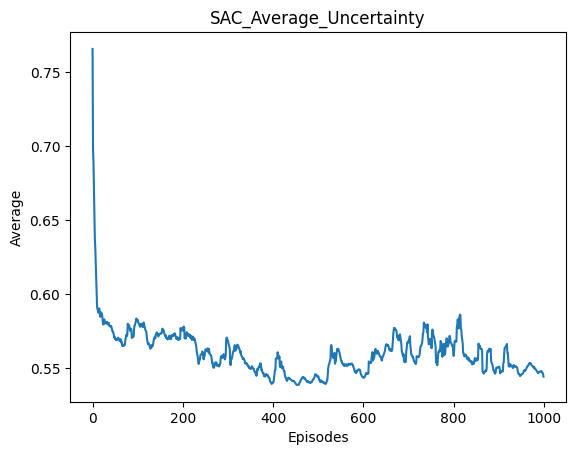

In [33]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC_Returns')
plt.show()
episodes_list = list(range(len(return_list_2)))
plt.plot(episodes_list, return_list_2)
plt.xlabel('Episodes')
plt.ylabel('Average Uncertainty')
plt.title('SAC_Average_Uncertainty')
plt.show()

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))
mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.title('SAC_Returns')
plt.show()
mv_return = moving_average(return_list_2, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Average')
plt.title('SAC_Average_Uncertainty')
plt.show()


In [ ]:
import pickle
from UAV_SAVE import *

# # 保存模型和训练历史
# save_sac_agent(agent, path='sac_model_checkpoint')
# save_training_history(return_list, return_list_2, path='training_history')

# 在另一个时间加载模型和训练历史
# 需要先创建一个新的SAC实例，然后加载状态
new_agent = SAC(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, alpha_lr, 
                target_entropy, tau, gamma, device)
new_agent = load_sac_agent(new_agent, path='sac_model_checkpoint',device=device)
return_list, return_list_2 = load_training_history(path='training_history')

In [ ]:
from UAV_VIS import *
avg_uncertainties = []
new_env = UAVEnv(2)
for u in range(10):
    avg_uncertainty = visualize_trajectory(new_agent, new_env)
    print(f"第{u+1}次平均不确定度: {avg_uncertainty:.6f}")
    avg_uncertainties.append(avg_uncertainty)

overall_avg_uncertainty = np.mean(avg_uncertainties)
print(f"10次可视化的平均不确定度: {overall_avg_uncertainty:.6f}")

之前的保存方案

In [ ]:
import pickle
import torch

# 保存模型状态字典
torch.save({
    'actor_state_dict': agent.actor.state_dict(),
    'critic1_state_dict': agent.critic_1.state_dict(),
    'critic2_state_dict': agent.critic_2.state_dict(),
    'target_critic1_state_dict': agent.target_critic_1.state_dict(),
    'target_critic2_state_dict': agent.target_critic_2.state_dict(),
    'log_alpha': agent.log_alpha.item()
}, 'sac_model.pth')

# 保存返回列表
results = {
    'return_list': return_list,
    'return_list_2': return_list_2
}
with open('return_lists.pkl', 'wb') as f:
    pickle.dump(results, f)

print("已保存模型状态和返回列表到当前目录")

In [ ]:
agent_test = SAC(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, alpha_lr,
            target_entropy, tau, gamma, device)

checkpoint = torch.load('sac_model.pth')
agent_test.actor.load_state_dict(checkpoint['actor_state_dict'])
agent_test.critic_1.load_state_dict(checkpoint['critic1_state_dict'])
agent_test.critic_2.load_state_dict(checkpoint['critic2_state_dict'])
agent_test.target_critic_1.load_state_dict(checkpoint['target_critic1_state_dict']) 
agent_test.target_critic_2.load_state_dict(checkpoint['target_critic2_state_dict'])
agent_test.log_alpha = torch.tensor(checkpoint['log_alpha'], requires_grad=True, device=device)

with open('return_lists.pkl', 'rb') as f:
    loaded_results = pickle.load(f)
return_list = loaded_results['return_list']
return_list_2 = loaded_results['return_list_2']